# Code to reproduce the figures found by Myles in Excel
Read in CO2 emissions per year, define a series of constants (not sure where these come from at the moment) and reproduce the graphs that Myles made in excel. The calculation of non-CO2 ERF changes prior to 2000, adding some complication to the code.
Next steps are to add error bars.


In [385]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 0. Packages, paths and functions

In [386]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# change the path  that points to the repository
# path = "C:\Users\galla\Documents\University Physics\Fourth Year Notes\MPhys_Project\2020_12_01InitialPaper\FlyingClimate-main\FlyingClimate-main\"
path = "~/git/FlyingClimate/"

In [2]:
# function to translate a column named by alphabet
# A,B,C,...AA,AB, etc into an index 0,1,2,...
def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

## 1. Define constants and factors

In [3]:
# define constants to be used. 
# From sheet 'Time Series' in spreadsheet

# effective radiative forcing (ERF) constants [mW/m^2/unit emission]
ERF = dict()                         # mean
ERFstd = dict()                      # uncertainty 1 standard deviation

# columns V-AD
ERF["O3short"] = 34.44               # ozone shortwave
ERF["CH4"] = -18.69                  # methane
ERF["O3long"] = -9.35                # ozone longwave
ERF["SWV"] = -2.80                   # stratospheric water vapour
ERF["netNOx"] = 5.46                 # nitrogen oxides (net)
ERF["BC"] = 100.67                   # black carbon
ERF["SO4"] = -19.91                  # sulphate
ERF["H2O"] = 0.0052                  # water vapour
ERF["contrail"] = 9.36e-10           # contrail and cirrus clouds [mW/m^2/km]

# same for uncertainty - 1 std
ERFstd["O3short"] = 9.9              # ozone shortwave
ERFstd["CH4"] = 6.9                  # methane
ERFstd["O3long"] = 3.4               # ozone longwave
ERFstd["SWV"] = 1.0                  # stratospheric water vapour
ERFstd["netNOx"] = 8.1               # nitrogen oxides (net)
ERFstd["BC"] = 165.5                 # black carbon
ERFstd["SO4"] = 16.0                 # sulphate
ERFstd["H2O"] = 0.0026               # water vapour
ERFstd["contrail"] = 0               # contrail and cirrus clouds [mW/m^2/km]

# other constants
Const = dict()
Const["distance_factor"] = 1.17
Const["total_to_civil"] = 0.95       # fraction
Const["EI_NOx"] = 15.14              # emission i? nitrogen oxides [g/kg fuel]
Const["EI_H2O"] = 1231.0             # emission i? water vapour [g/kg fuel]
Const["EI_BC"] = 0.03                # emission i? black carbon [g/kg fuel]
Const["EI_SO2"] = 1.2                # emission i? sulph[g/kg fuel]

# efficacies
efficacy_o3short = 1.37
efficacy_ch4 = 1.18

In [4]:
# Emission I? of nitrogen oxides
einox_years = np.arange(1976,2019)
EINOx = np.empty(len(einox_years))

# spot data
EINOx[einox_years == 1976] = 9.8
EINOx[einox_years == 1984] = 11.0
EINOx[einox_years == 1992] = 12.90
EINOx[einox_years == 2000] = 13.80
EINOx[einox_years == 2005] = 14.20
EINOx[einox_years == 2010] = 15.14

# keep constant in the future
EINOx[einox_years > 2010] = EINOx[einox_years == 2010]

# interpolate in between
for p in [(1976,1984),(1984,1992),(1992,2000),(2000,2005),(2005,2010)]:
    period = (einox_years >= p[0])*(einox_years <= p[1])
    slope = np.diff(EINOx[period][[-1,0]])[0]/ \
                    np.diff(einox_years[period][[-1,0]])[0]
    EINOx[period] = slope*(einox_years[period]-einox_years[period][0]) + \
                    EINOx[period][0]

In [5]:
np.vstack((einox_years,EINOx)).T

array([[1976.    ,    9.8   ],
       [1977.    ,    9.95  ],
       [1978.    ,   10.1   ],
       [1979.    ,   10.25  ],
       [1980.    ,   10.4   ],
       [1981.    ,   10.55  ],
       [1982.    ,   10.7   ],
       [1983.    ,   10.85  ],
       [1984.    ,   11.    ],
       [1985.    ,   11.2375],
       [1986.    ,   11.475 ],
       [1987.    ,   11.7125],
       [1988.    ,   11.95  ],
       [1989.    ,   12.1875],
       [1990.    ,   12.425 ],
       [1991.    ,   12.6625],
       [1992.    ,   12.9   ],
       [1993.    ,   13.0125],
       [1994.    ,   13.125 ],
       [1995.    ,   13.2375],
       [1996.    ,   13.35  ],
       [1997.    ,   13.4625],
       [1998.    ,   13.575 ],
       [1999.    ,   13.6875],
       [2000.    ,   13.8   ],
       [2001.    ,   13.88  ],
       [2002.    ,   13.96  ],
       [2003.    ,   14.04  ],
       [2004.    ,   14.12  ],
       [2005.    ,   14.2   ],
       [2006.    ,   14.388 ],
       [2007.    ,   14.576 ],
       [

In [6]:
# transient factor - what's that?
tf_years = np.arange(1980,2051)
transient_factor = np.empty(len(tf_years))

# spot data
transient_factor[tf_years == 2001] = 0.73
transient_factor[tf_years == 2005] = 0.75
transient_factor[tf_years == 2010] = 0.78
transient_factor[tf_years == 2018] = 0.79
transient_factor[tf_years == 2050] = 0.80

# keep constant into past & future
transient_factor[tf_years < 2001] = transient_factor[tf_years == 2001]

# interpolate in between
for p in [(2001,2005),(2005,2010),(2010,2018),(2018,2050)]:
    period = (tf_years >= p[0])*(tf_years <= p[1])
    slope = np.diff(transient_factor[period][[-1,0]])[0]/ \
                    np.diff(tf_years[period][[-1,0]])[0]
    transient_factor[period] = slope*(tf_years[period]-tf_years[period][0]) + \
                    transient_factor[period][0]

In [17]:
np.vstack((tf_years,transient_factor)).T

array([[1.980000e+03, 7.300000e-01],
       [1.981000e+03, 7.300000e-01],
       [1.982000e+03, 7.300000e-01],
       [1.983000e+03, 7.300000e-01],
       [1.984000e+03, 7.300000e-01],
       [1.985000e+03, 7.300000e-01],
       [1.986000e+03, 7.300000e-01],
       [1.987000e+03, 7.300000e-01],
       [1.988000e+03, 7.300000e-01],
       [1.989000e+03, 7.300000e-01],
       [1.990000e+03, 7.300000e-01],
       [1.991000e+03, 7.300000e-01],
       [1.992000e+03, 7.300000e-01],
       [1.993000e+03, 7.300000e-01],
       [1.994000e+03, 7.300000e-01],
       [1.995000e+03, 7.300000e-01],
       [1.996000e+03, 7.300000e-01],
       [1.997000e+03, 7.300000e-01],
       [1.998000e+03, 7.300000e-01],
       [1.999000e+03, 7.300000e-01],
       [2.000000e+03, 7.300000e-01],
       [2.001000e+03, 7.300000e-01],
       [2.002000e+03, 7.350000e-01],
       [2.003000e+03, 7.400000e-01],
       [2.004000e+03, 7.450000e-01],
       [2.005000e+03, 7.500000e-01],
       [2.006000e+03, 7.560000e-01],
 

## 2. Read in data from CSV

In [131]:
### read in the data
fuel_usage = pd.read_csv(path+"data/fuel_co2.csv")
years = fuel_usage["year"]

In [8]:
fuel_usage

,year,Fuel [Tg/yr],CO2 [Tg/yr],distance [million km]
0,1980,128.732000,406.793120,9350.000000
1,1981,126.552000,399.904320,9113.000000
2,1982,128.181000,405.051960,9140.000000
3,1983,130.347000,411.896520,9395.000000
4,1984,139.045000,439.382200,10102.000000
5,1985,143.439000,453.267240,10598.000000
6,1986,151.484000,478.689440,11491.000000
7,1987,158.448000,500.695680,12266.000000
8,1988,166.128000,524.964480,13017.000000
9,1989,172.991000,546.651560,13493.000000


## 3. Emissions per year 1980-2018

In [9]:
fuel = fuel_usage["Fuel [Tg/yr]"]

# conversion factor Terragram [1e12] to kilogram [1e3]
Tg2kg = 1e9
g2Tg = 1e12
g2kg = 1e-3

# CO2 emissions from flying per year
co2 = fuel_usage["CO2 [Tg/yr]"]

# total flown distance in [km]
scaled_distance = fuel_usage["distance [million km]"]*Const["distance_factor"]*1e6

# black carbon emissions [Tg/yr]
bc = fuel*(Const["EI_BC"]*g2kg)*Const["total_to_civil"]

# sulphur dioxide emissions [Tg/yr]
so2 = fuel*(Const["EI_SO2"]*g2kg)*Const["total_to_civil"]

# nitrogen oxide emissions [cut off year 1976-1979 from EINOx]
nox = fuel*(EINOx[einox_years > 1979]*g2kg)*Const["total_to_civil"]*(14/46)  # WHY 14/46?

# water vapour
h2o = fuel*(Const["EI_H2O"]*g2kg)*Const["total_to_civil"]

## 4.1 Radiative forcings of CO2 via LinClim, CICERO, FAIR 1940-2018

In [173]:
# load LinClim, CICERO and FAIR from file
CO2_RF = pd.read_csv(path+"data/CO2_radiative_forcings.csv")
co2rf_years = CO2_RF["year"]

# pull radiative forcings from models
co2rf_linclim = CO2_RF["LinClim CO2 RF"]
co2rf_cicero = CO2_RF["CICERO CO2 RF"]
co2rf_fair = CO2_RF["FAIR CO2 RF"]

# model mean
co2rf_mean = 1/3*(co2rf_linclim+co2rf_cicero+co2rf_fair).to_numpy()

In [66]:
np.vstack((co2rf_years,co2rf_mean)).T

array([[1.94000000e+03, 7.00000000e-02],
       [1.94100000e+03, 1.43333333e-01],
       [1.94200000e+03, 2.10000000e-01],
       [1.94300000e+03, 2.80000000e-01],
       [1.94400000e+03, 3.60000000e-01],
       [1.94500000e+03, 4.36666667e-01],
       [1.94600000e+03, 5.23333333e-01],
       [1.94700000e+03, 6.10000000e-01],
       [1.94800000e+03, 7.10000000e-01],
       [1.94900000e+03, 8.13333333e-01],
       [1.95000000e+03, 9.23333333e-01],
       [1.95100000e+03, 1.03666667e+00],
       [1.95200000e+03, 1.16333333e+00],
       [1.95300000e+03, 1.30000000e+00],
       [1.95400000e+03, 1.44333333e+00],
       [1.95500000e+03, 1.59666667e+00],
       [1.95600000e+03, 1.76333333e+00],
       [1.95700000e+03, 1.94000000e+00],
       [1.95800000e+03, 2.13333333e+00],
       [1.95900000e+03, 2.34000000e+00],
       [1.96000000e+03, 2.56000000e+00],
       [1.96100000e+03, 2.80333333e+00],
       [1.96200000e+03, 3.07000000e+00],
       [1.96300000e+03, 3.34666667e+00],
       [1.964000

## 4.2 Effective radiative forcings of O3, CH4, SWV, netNOX, BC, SO4, H20, contrails

In [10]:
o3short_rf = nox*ERF["O3short"]
ch4_rf = nox*ERF["CH4"]*transient_factor[tf_years < 2019]
o3long_rf = nox*ERF["O3long"]*transient_factor[tf_years < 2019]
swv_rf = nox*ERF["SWV"]*transient_factor[tf_years < 2019]
bc_rf = bc*ERF["BC"]
so4_rf = so2*ERF["SO4"]     # SO2 vs SO4, correct?
h2o_rf = h2o*ERF["H2O"]
contrail_rf = scaled_distance*ERF["contrail"]

## 4.3 NOx forcing from multi-study median

For each study, calculate the sum of NOx forcing as:

- Short-term O3 RF (mW/m2 / Tg N) * efficacy of short-term O3 effects

- +CH4 RF (mW/m2 / Tg N) * efficacy of CH4 * Transient factor for NOx for the year of interest

- +Long-term O3 RF (mW/m2 / Tg N) * efficacy of CH4 * Transient factor for the year of interest

- +SWV RF (mW/m2 / TgN) * efficacy of CH4 * Transient factor for the year of interest

In [44]:
# pull the data
NOx_xlsx = pd.read_excel(path+"data/NOx_radiative_forcing.xlsx")

In [110]:
# read out all values of O3short RF, CH4 RF, O3long RF and SWV RF from sheet
# use only those studies that have values for all 4, they are separated by 2 empty rows, find them
nox_allstudies = NOx_xlsx.values[:,ABC2index("Z")]
nox_allstudies = nox_allstudies[9:].astype(np.float)         # cut header
missing = -999999.0

NOxRFs = []  # all NOx forcings (o3short,ch4,o3long,stratospheric water vapour swv) for all studies
for i in np.arange(2,len(nox_allstudies)-1):
    
    # find a new set of studies (separated by 2 rows with nans)
    if ~np.isnan(nox_allstudies[i]) and np.isnan(nox_allstudies[i-1]) and np.isnan(nox_allstudies[i-2]):

        j = i+1
        
        # find the end of that set (separated by 2 rows with nans again)
        while ~(~np.isnan(nox_allstudies[j]) and 
                np.isnan(nox_allstudies[j-1]) and 
                np.isnan(nox_allstudies[j-2])) and j < len(nox_allstudies)-1:
            j+=1
        
        a = nox_allstudies[i:j-2]  # cut off last two nans
        if np.sum(~np.isnan(a)) % 4 == 0:  # only for 4i values in set ()
            a_reshaped = np.array(a[~np.isnan(a)]).reshape(4,-1).T  # reshape to represent individual studies
            for ar in a_reshaped:
                if not missing in ar:  # add only if missing is not in the study
                    NOxRFs.append(ar)

# convert to numpy array
NOxRFs = np.array(NOxRFs)

In [123]:
nstudies = A.shape[0]                      # number of studies (60)
nox_years = np.arange(1980,2019)           # array with years
NOxA = np.empty((len(nox_years),nstudies)) # array of sum of NOx forcings by years and study 

for iy,year in enumerate(nox_years):
    transient_f = transient_factor[tf_years == year]
    for si in range(nstudies):
        o3short_rfs,ch4_rfs,o3long_rfs,swv_rfs = NOxRFs[si,:]
        NOxA[iy,si] = efficacy_o3short*o3short_rfs + \
                        efficacy_ch4*ch4_rfs*transient_f + \
                        efficacy_ch4*o3long_rfs*transient_f +\
                        efficacy_ch4*swv_rfs*transient_f

# Now finally the effective radiative forcing of NOx
noxm_rf = np.median(NOxA,axis=1)*nox
nox5_rf = np.percentile(NOxA,5,axis=1)*nox
nox95_rf = np.percentile(NOxA,95,axis=1)*nox

## 5. Sum non-CO2 radiative forcings

In [215]:
nonCO2_rf = o3short_rf + ch4_rf + o3long_rf + swv_rf +\
            bc_rf + so4_rf + h2o_rf + contrail_rf

## 6. Plot aviation emission per year and cumulative

In [462]:
# projections into the future
years_future = np.arange(2018,2051)
co2_scenario1 = np.zeros(len(years_future))     # 1.4% decline per year
co2_scenario2 = np.zeros(len(years_future))     # 0% decline per year
co2_scenario3 = np.zeros(len(years_future))     # 1.4% incline per year

percent_decline1 = 2    # per year
percent_decline2 = 0      # per year
percent_decline3 = -2   # per year

co2_scenario1[0] = co2[years == 2018]
co2_scenario2[0] = co2[years == 2018]
co2_scenario3[0] = co2[years == 2018]

for i in range(1,len(years_future)):
    co2_scenario1[i] = co2_scenario1[i-1]*(1-percent_decline1/100)
    co2_scenario2[i] = co2_scenario2[i-1]*(1-percent_decline2/100)
    co2_scenario3[i] = co2_scenario3[i-1]*(1-percent_decline3/100)

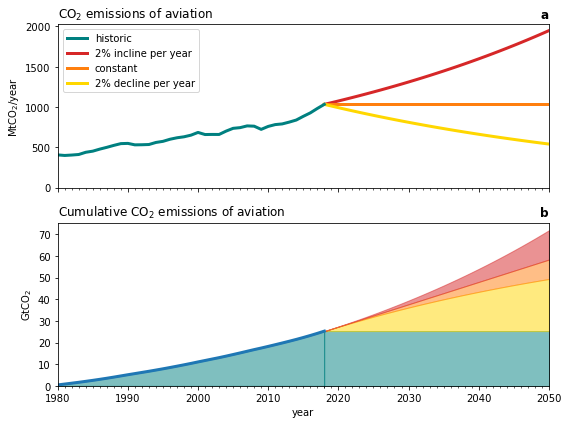

In [463]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)

# historic
ax1.plot(years,co2,"teal",lw=3,label="historic")
ax2.fill_between(years,np.cumsum(co2)/1000,alpha=0.5,color="teal")
ax2.plot(years,np.cumsum(co2)/1000,lw=3)

# future scenarios
ax1.plot(years_future,co2_scenario3,"C3",lw=3,zorder=-1,label="2% incline per year")
ax1.plot(years_future,co2_scenario2,"C1",lw=3,zorder=-1,label="constant")
ax1.plot(years_future,co2_scenario1,"gold",lw=3,zorder=-1,label="2% decline per year")

ax2.fill_between(years_future,np.ones_like(years_future)*np.sum(co2)/1000,alpha=0.5,color="teal")
ax2.fill_between(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 np.sum(co2)/1000,alpha=0.5,color="gold")
ax2.fill_between(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,alpha=0.5,color="C1")
ax2.fill_between(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,alpha=0.5,color="C3")

ax1.set_title(r"CO$_2$ emissions of aviation",loc="left")
ax2.set_title(r"Cumulative CO$_2$ emissions of aviation",loc="left")
ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")

ax1.set_ylabel(r"MtCO$_2$/year")
ax2.set_ylabel(r"GtCO$_2$")
ax2.set_xlabel("year")
ax1.legend(loc=2)

ax1.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])
ax2.set_ylim(0,ax2.get_ylim()[1])
ax1.set_xticks(np.hstack((years,years_future)),minor=True)
plt.tight_layout()

## 6.1 Plot non-CO2 radiative forcing timeseries with future

In [464]:
# projections into the future
years_future = np.arange(2018,2051)
co2rf_scenario1 = np.zeros(len(years_future))     # p% decline per year
co2rf_scenario2 = np.zeros(len(years_future))     # 0% decline per year
co2rf_scenario3 = np.zeros(len(years_future))     # p% incline per year

nonco2rf_scenario1 = np.zeros(len(years_future))     # p% decline per year
nonco2rf_scenario2 = np.zeros(len(years_future))     # 0% decline per year
nonco2rf_scenario3 = np.zeros(len(years_future))     # p% incline per year

percent_decline1 = 2   # per year
percent_decline2 = 0   # per year
percent_decline3 = -2   # per year

co2rf_scenario1[0] = co2rf_mean1980[years == 2018]
co2rf_scenario2[0] = co2rf_mean1980[years == 2018]
co2rf_scenario3[0] = co2rf_mean1980[years == 2018]

nonco2rf_scenario1[0] = nonCO2_rf[years == 2018]
nonco2rf_scenario2[0] = nonCO2_rf[years == 2018]
nonco2rf_scenario3[0] = nonCO2_rf[years == 2018]

for i in range(1,len(years_future)):
    co2rf_scenario1[i] = co2rf_scenario1[i-1]*(1-percent_decline1/100)
    co2rf_scenario2[i] = co2rf_scenario2[i-1]*(1-percent_decline2/100)
    co2rf_scenario3[i] = co2rf_scenario3[i-1]*(1-percent_decline3/100)
    
    nonco2rf_scenario1[i] = nonco2rf_scenario1[i-1]*(1-percent_decline1/100)
    nonco2rf_scenario2[i] = nonco2rf_scenario2[i-1]*(1-percent_decline2/100)
    nonco2rf_scenario3[i] = nonco2rf_scenario3[i-1]*(1-percent_decline3/100)

In [465]:
# Cumulative CO2 forcing-equivalent emissions of non-CO2 effects

alpha = 0.0       # BB6, WHAT'S THIS?
AGWP100 = 91.7    # Absolute global warming potential [1], BB7 OF WHAT?
H = 100.0         # BB8, WHAT'S THIS?
TCRE = 0.00045    # Transient climate response to cumulative
                  # carbon emissions [K/(mW/m^2)], BB9

# CO2 forcing-equivalent emissions (historic)
nonCO2_cumemissions = (1-alpha)*(H/AGWP100)*(nonCO2_rf - nonCO2_rf[0]) + (alpha/AGWP100)*nonCO2_rf*(years-years[0])

# calculate warming as a linear function of climate response TCRE
CO2_warming = co2rf_mean1980*TCRE
nonCO2_warming = nonCO2_cumemissions*TCRE

# future scenarios for nonCO2_warming
nonco2_cumemiss_scenario1 = (1-alpha)*(H/AGWP100)*(nonco2rf_scenario1 - nonCO2_rf[0]) +\
                            (alpha/AGWP100)*nonco2rf_scenario1*(years_future-years[0])

nonco2_cumemiss_scenario2 = (1-alpha)*(H/AGWP100)*(nonco2rf_scenario2 - nonCO2_rf[0]) +\
                            (alpha/AGWP100)*nonco2rf_scenario2*(years_future-years[0])

nonco2_cumemiss_scenario3 = (1-alpha)*(H/AGWP100)*(nonco2rf_scenario3 - nonCO2_rf[0]) +\
                            (alpha/AGWP100)*nonco2rf_scenario3*(years_future-years[0])


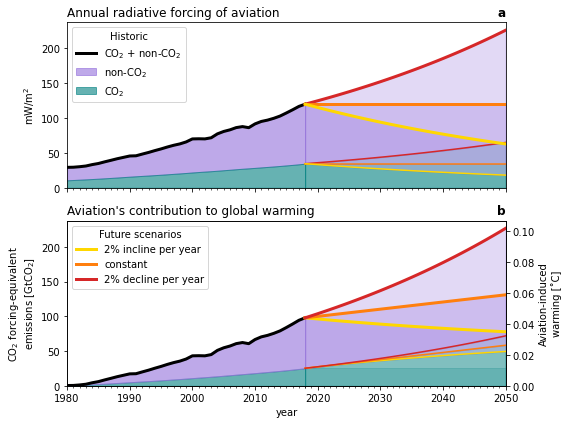

In [479]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)
ax2r = ax2.twinx()   # put warming on a second y-axis

# historic
alfa=0.6
h = lambda y: 1-np.cbrt(1-y)  # three-level superimposed alpha
h4 = lambda y: 1-np.sqrt(np.sqrt(1-y))  # four-level superimposed alpha

ax1.fill_between(years,nonCO2_rf+co2rf_mean1980,co2rf_mean1980,color="mediumpurple",alpha=alfa,label="non-CO$_2$")
ax1.fill_between(years,co2rf_mean1980,color="teal",alpha=alfa,label=r"CO$_2$")
ax1.plot(years,co2rf_mean1980+nonCO2_rf,"k",lw=3,label=r"CO$_2$ + non-CO$_2$")

# cumulative
ax2.fill_between(years,np.cumsum(co2)/1000,alpha=alfa,color="teal")
ax2.fill_between(years,nonCO2_cumemissions+np.cumsum(co2)/1000,np.cumsum(co2)/1000,alpha=alfa,color="mediumpurple")
ax2.plot(years,nonCO2_cumemissions+np.cumsum(co2)/1000,"k",lw=3)

# future scenarios
ax1.fill_between(years_future,co2rf_scenario3,color="teal",alpha=h(alfa))
ax1.fill_between(years_future,co2rf_scenario2,color="teal",alpha=h(alfa))
ax1.fill_between(years_future,co2rf_scenario1,color="teal",alpha=h(alfa))

ax1.plot(years_future,co2rf_scenario3,"C3")
ax1.plot(years_future,co2rf_scenario2,"C1")
ax1.plot(years_future,co2rf_scenario1,"gold")

ax1.fill_between(years_future,nonco2rf_scenario3+co2rf_scenario3,co2rf_scenario3,color="mediumpurple",alpha=h(alfa))
ax1.fill_between(years_future,nonco2rf_scenario2+co2rf_scenario2,co2rf_scenario2,color="mediumpurple",alpha=h(alfa))
ax1.fill_between(years_future,nonco2rf_scenario1+co2rf_scenario1,co2rf_scenario1,color="mediumpurple",alpha=h(alfa))

ax1.plot(years_future,nonco2rf_scenario3+co2rf_scenario3,"C3",lw=3)
ax1.plot(years_future,nonco2rf_scenario2+co2rf_scenario2,"C1",lw=3)
ax1.plot(years_future,nonco2rf_scenario1+co2rf_scenario1,"gold",lw=3)

# cumulative future
# CO2
ax2.fill_between(years_future,np.ones_like(years_future)*np.sum(co2)/1000,alpha=h4(alfa),color="teal")
ax2.fill_between(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 alpha=h4(alfa),color="teal")
ax2.fill_between(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 alpha=h4(alfa),color="teal")
ax2.fill_between(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 alpha=h4(alfa),color="teal")

ax2.plot(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,"gold")
ax2.plot(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,"C1")
ax2.plot(years_future,np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,"C3")

# NON-CO2
ax2.plot(years_future,nonco2_cumemiss_scenario1+np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,"gold",lw=3,label="2% incline per year")
ax2.plot(years_future,nonco2_cumemiss_scenario2+np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,"C1",lw=3,label="constant")
ax2.plot(years_future,nonco2_cumemiss_scenario3+np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,"C3",lw=3,label="2% decline per year")

ax2.fill_between(years_future,nonco2_cumemiss_scenario1+np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 np.sum(co2[:-1])/1000+np.cumsum(co2_scenario1)/1000,
                 alpha=h(alfa),color="mediumpurple")
ax2.fill_between(years_future,nonco2_cumemiss_scenario2+np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 np.sum(co2[:-1])/1000+np.cumsum(co2_scenario2)/1000,
                 alpha=h(alfa),color="mediumpurple")
ax2.fill_between(years_future,nonco2_cumemiss_scenario3+np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 np.sum(co2[:-1])/1000+np.cumsum(co2_scenario3)/1000,
                 alpha=h(alfa),color="mediumpurple")

ax1.set_title(r"Annual radiative forcing of aviation",loc="left")
# ax2.set_title(r"Cumulative CO$_2$ forcing-equivalent emissions / Aviation-induced warming",loc="left")
ax2.set_title(r"Aviation's contribution to global warming",loc="left")
ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
# ax3.set_title("c",loc="right",fontweight="bold")

ax1.set_ylabel(r"mW/m$^2$")
ax2.set_ylabel(r"CO$_2$ forcing-equivalent"+"\n"+"emissions [GtCO$_2$]")
ax2r.set_ylabel("Aviation-induced\nwarming [˚C]")
ax2.set_xlabel("year")
ax1.legend(loc=2,title="Historic")
ax2.legend(loc=2,title="Future scenarios")

ax1.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])
ax2.set_ylim(0,ax2.get_ylim()[1])
ax2r.set_ylim(0,TCRE*ax2.get_ylim()[1])
ax1.set_xticks(np.hstack((years,years_future)),minor=True)
plt.tight_layout()
plt.savefig()"

## 7. Plot individual ERFs for aviation

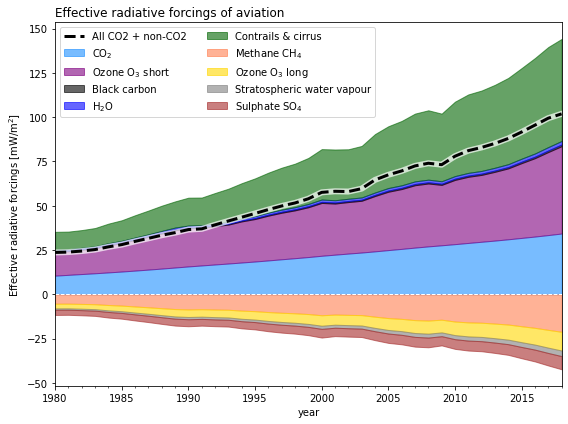

In [289]:
fig,ax1 = plt.subplots(1,1,figsize=(8,6),sharex=True)

co2rf_mean1980 = co2rf_mean[co2rf_years > 1979]

alfa=0.6
# pack all radiative forcings in one array
all_positive_rfs = np.array([np.zeros_like(years),
                             co2rf_mean1980,
                             o3short_rf,
                             bc_rf,
                             h2o_rf,
                             contrail_rf])

all_negative_rfs = np.array([np.zeros_like(years),
                             ch4_rf,
                             o3long_rf,
                             swv_rf,
                             so4_rf])

rf_posnames = [r"CO$_2$",r"Ozone O$_3$ short","Black carbon",r"H$_2$O","Contrails & cirrus"]
rf_negnames = [r"Methane CH$_4$",r"Ozone O$_3$ long","Stratospheric water vapour",r"Sulphate SO$_4$"]
poscolours = ["","dodgerblue","purple","k","blue","darkgreen","red"]
negcolours = ["","coral","gold","grey","brown"]
for i in range(1,all_positive_rfs.shape[0]):
    ax1.fill_between(years,
                     np.sum(all_positive_rfs[:i+1,:],axis=0),
                     np.sum(all_positive_rfs[:i,:],axis=0),
                     alpha=alfa,label=rf_posnames[i-1],
                     edgecolor="white",color=poscolours[i])
    
for i in range(1,all_negative_rfs.shape[0]):
    ax1.fill_between(years,
                     np.sum(all_negative_rfs[:i+1,:],axis=0),
                     np.sum(all_negative_rfs[:i,:],axis=0),
                     alpha=alfa,label=rf_negnames[i-1],
                     edgecolor="white",color=negcolours[i])

ax1.plot(years,np.sum(all_negative_rfs,axis=0)+np.sum(all_positive_rfs,axis=0),"w",lw=6,alpha=0.7)
ax1.plot(years,np.sum(all_negative_rfs,axis=0)+np.sum(all_positive_rfs,axis=0),"k--",lw=3,label="All CO2 + non-CO2")
ax1.plot(years,np.zeros_like(years),"w--",lw=1)
    
ax1.set_title("Effective radiative forcings of aviation",loc="left")
ax1.legend(loc=2,ncol=2)

ax1.set_ylabel(r"Effective radiative forcings [mW/m$^2$]")
ax1.set_xlabel("year")

ax1.set_xlim(1980,2018)
# ax1.set_ylim(0,ax1.get_ylim()[1])
ax1.set_xticks(years,minor=True)
plt.tight_layout()